## Outline
    1. Generators 
    2. Augmentation
    3. Training 
    4. Callbacks
    5. Inference
    6. Bonus Note!

        
Convolutional networks ([ConvNets](https://en.wikipedia.org/wiki/Convolutional_neural_network)) have had great success in large-scale image
and video recognition which has become possible due to the large public image repositories,
such as [ImageNet](http://www.image-net.org/), and high-performance computing systems, such as GPUs
or large-scale distributed clusters.

[keras](https://keras.io/) is a user friendly framework that allows for easy and fast prototyping, supports both convolutional and recurrent networks, and runs seasmlessly on CPU and GPU.


In this notebook we will walk through the steps required to build, train and monitor an image classifier.

---


## 1. Generators

The easiest way to feed data into a network in `keras` is through a generator. A generator allows us to easily define the source and processing of our data. Here is a simple example:

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Found 92 images belonging to 12 classes.
Some of our training data:


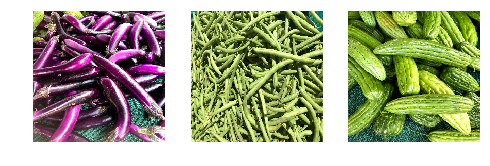

In [1]:
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize our generator, choosing to shuffle our images and the batch size.
gen = ImageDataGenerator().flow_from_directory('data/farmer_market',
                                               shuffle=True, 
                                               batch_size=9)
# Here we see its output for the first batch.
# This should be the batch of inputs with the matching labels
images, labels = gen[0]

# Let's look at how our data looks like
print("Some of our training data:")
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
count = 0
for j in range (3):
    ax[j].imshow(images[count].astype(np.uint8))
    ax[j].axis('off')
    count += 1


---

## 2. Data Augmentation
In a general sense, data augmentation allows us to work with more data points than we have. Specifically for images, this means introducing rotations, scaling, brightness, saturation, zooming and many other perturbations to make our model more robust and unbiased. 

Here is an example of how that looks:

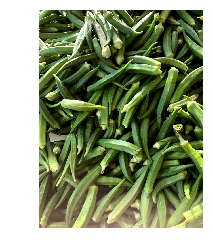

In [2]:
img = cv2.imread('data/farmer_market/okra/IMG_8683.jpg')[:,:,::-1]
plt.axis('off')
plt.imshow(img)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


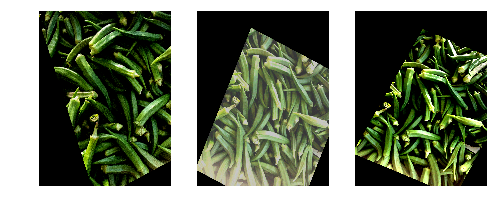

In [3]:
from imgaug import augmenters as iaa
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.15)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.55, 1.8)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.7),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.5, 1.5), per_channel=0.4),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-35, 35),
        shear=(-12, 12)
    )
    ], random_order=True)

imgs = [img]*3

aug_imgs = seq.augment_images(imgs)

fig, ax = plt.subplots(1, 3, figsize=(8,8))
count = 0
for j in range (3):
    ax[j].imshow(aug_imgs[count].astype(np.uint8))
    ax[j].axis('off')
    count += 1


`keras` makes it very easy to combine the augmentation with the generator. For example, we can easily include the previous augmentations with:
```python
rescaled_aug = lambda x: seq.augment_image(x)/255
datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=rescaled_aug)
```
If we want simpler (i.e. less flexible) augmentation we can also use `ImageDataGenerator`'s arguments as we will do below. 

#### Note about object detection

If instead of image clasification we were doing object detection (where we need to pass class label as well as bounding box coordinates) we might consider using custom augmentation, and maybe writing our own generator by overloading `Sequence` (you can check out an example of this in my `keras` [implementation of the object detector YOLO v2](https://github.com/ksanjeevan/dourflow/blob/master/net/netgen.py)).

---

Given that our `farmer-market` dataset is small (FOR NOW!), we will proceed with an equivalent task on the [kaggle](https://www.kaggle.com) dataset [flowers-recognition](https://www.kaggle.com/alxmamaev/flowers-recognition).
The dataset can be downloaded using the kaggle API, by running:
```bash
kaggle datasets download -d alxmamaev/flowers-recognition
```

or from my google drive account [here](https://drive.google.com/file/d/1blNYuDVxFhUh-XmL8QcQj2iCfrpNZjDa/view?usp=sharing).

Let's use `ImageDataGenerator`'s simple augmentation and see how the data looks:


Found 3243 images belonging to 5 classes.
Found 1080 images belonging to 5 classes.


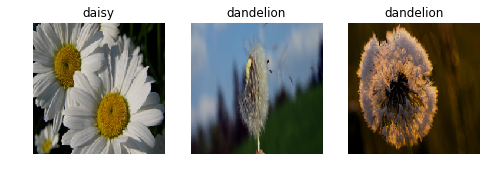

In [4]:
KAGGLE_PATH = './flowers'

# Read more here: https://keras.io/preprocessing/image/#imagedatagenerator-class
datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=15,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #channel_shift_range=0.1,
    brightness_range=[0.6,1.4],
    zoom_range=[.4, 1.],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.25,
    fill_mode='nearest')


# Some of the generator arguments before we call `flow`
gen_args = dict(
    directory = KAGGLE_PATH,
    target_size = (224,224),
    class_mode = 'sparse',
    batch_size=16,
    shuffle=True
)

# Create training and validation generators
train_gen = datagen.flow_from_directory(subset='training', **gen_args)
val_gen = datagen.flow_from_directory(subset='validation', **gen_args)

# Important to store the mapping of index -> class label
# for inference later
decode_map = {v: k for k, v in train_gen.class_indices.items()}

# Let's look at a few
images, labels = train_gen[0]
fig, ax = plt.subplots(1, 3, figsize=(8,8))
count = 0
for j in range (3):
    ax[j].imshow((255*images[count]).astype(np.uint8))
    ax[j].axis('off')
    ax[j].set_title(decode_map[labels[count]])

    count += 1


---

## 3. Training
### 3.1 Model selection
It's now time to begin training our network (we won't get into all the different architectures). Since classification is a well solved problem, we will use VGG16 for its high performance and not bother trying to reinvent the wheel.

### 3.2 Transfer learning
Another reason to use a well known architecture is that researchers who spend weeks carefully training them usually publish their weights, and we can take advantage of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). `keras` makes this again very easy by automatically downloading the weights for [ImageNet](http://www.image-net.org/) when initializing the model (we could also choose to train from scratch but that is not a trivial task).


Let's take a look at VGG16:

In [5]:
from keras.applications import VGG16
vgg_base = VGG16()
print(vgg_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
from keras.layers import Dense
from keras.models import Model

# To do transfer learning we will have to remove the last layer and\
# replace it with a randomized one of appropiate size.
def update_model(model, out_size):
    new_out = Dense(
        out_size, 
        activation='softmax', 
        name='predictions')(model.layers[-2].output)

    return Model(inputs=model.inputs, outputs=new_out)

## 4. Callbacks

Callbacks allow us to run evaluations and record metrics at the end of an epoch, and write them to `tensorboard` or print them to screen for monitoring. When doing classification it's a good idea to keep track of precision and recall.

Before we begin training we'll take a look at the `Callback` class:

In [7]:
from keras.callbacks import Callback
from tqdm import tqdm
from sklearn.metrics import recall_score, precision_score
import pandas as pd

class Metrics(Callback):
    
    def __init__(self, generator):
        self.generator = generator
        super(Metrics, self).__init__()
        
    def on_train_begin(self, logs={}):
        self.val_losses = [float('inf')]
        self.metrics = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        self.val_losses.append(logs['val_loss'])
        
        if self.val_losses[-2] > self.val_losses[-1]:
            
            y_true = []; y_pred = []
            for batch in range(len(self.generator)):
                images, labels = self.generator[batch]
                y_pred.append(self.model.predict(images))
                y_true.append(labels)
            
            y_pred = np.concatenate(y_pred, axis=0)    
            y_true = np.concatenate(y_true, axis=0)    
            y_pred_winner = np.argmax(y_pred, axis=-1)
            
            recall = recall_score(y_true, y_pred_winner, average=None)
            precision = precision_score(y_true, y_pred_winner, average=None)
            self.metrics.append({'precision':precision, 'recall':recall})
        
        # Get the window=3 moving average
        r = np.mean([m['recall'] for m in self.metrics[-3:]], axis=0)
        p = np.mean([m['precision'] for m in self.metrics[-3:]], axis=0)
        index = [decode_map[i] for i in range(len(p))]
        
        df = pd.DataFrame()
        df['Precision'] = p
        df['Recall'] = r
        df.index = index
        print(df)
        

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


---
**Note on training:**
We will need a GPU for training due to the computational intensity. If our machine is not equipped with a GPU, a good option is to use an [aws ec2 instance](https://aws.amazon.com/ec2/instance-types/) (of type 'P'). 

Then work with this notebook by running on the remote server side:
```bash
jupyter notebook --no-browser --port=8888
```
and then on your local machine:
```bash
ssh -N -L localhost:8000:localhost:8888 username@ec2-instance
```
Now by logging into a browser and going to `localhost:8000` we can access our remote notebook.

---

In [10]:
# Let's begin training

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

LR = 0.0002
TRAIN_STEPS, VAL_STEPS = 250, 50
NUM_EPOCHS = 100
PATIENCE=3

model = update_model(vgg_base, train_gen.num_classes)

early_stop = EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,
            patience=PATIENCE,
            mode='min',
            verbose=1)

checkpoint = ModelCheckpoint(
        './tutorial_weights.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        period=1,
        save_weights_only=True)

metrics = Metrics(val_gen)

model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(lr=LR), 
        metrics=['acc'])

train_data = model.fit_generator(
        train_gen,
        steps_per_epoch=TRAIN_STEPS,
        epochs=NUM_EPOCHS,
        validation_data=val_gen,
        validation_steps=VAL_STEPS,
        callbacks=[checkpoint, early_stop, metrics])

Epoch 1/100
250/250 [==============================] - 59s 235ms/step - loss: 1.5996 - acc: 0.3366 - val_loss: 1.2566 - val_acc: 0.4713

Epoch 00001: val_loss improved from inf to 1.25658, saving model to ./tutorial_weights.h5
1
           Precision    Recall
daisy       0.000000  0.000000
dandelion   0.571429  0.790875
rose        0.280000  0.107143
sunflower   0.365942  0.551913
tulip       0.509589  0.756098
Epoch 2/100
  1/250 [..............................] - ETA: 47s - loss: 1.2744 - acc: 0.3750

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


250/250 [==============================] - 52s 208ms/step - loss: 1.2447 - acc: 0.4724 - val_loss: 1.0833 - val_acc: 0.5637

Epoch 00002: val_loss improved from 1.25658 to 1.08329, saving model to ./tutorial_weights.h5
2
           Precision    Recall
daisy       0.252577  0.255208
dandelion   0.685304  0.766160
rose        0.390000  0.056122
sunflower   0.481854  0.568306
tulip       0.486899  0.813008
Epoch 3/100
250/250 [==============================] - 53s 211ms/step - loss: 1.1167 - acc: 0.5334 - val_loss: 1.0640 - val_acc: 0.5387

Epoch 00003: val_loss improved from 1.08329 to 1.06401, saving model to ./tutorial_weights.h5
3
           Precision    Recall
daisy       0.369774  0.321181
dandelion   0.745877  0.717364
rose        0.426667  0.042517
sunflower   0.470433  0.666667
tulip       0.498549  0.817073
Epoch 4/100
250/250 [==============================] - 54s 214ms/step - loss: 1.0579 - acc: 0.5710 - val_loss: 1.0491 - val_acc: 0.5863

Epoch 00004: val_loss improved from 1

We can then look at `train_data.history` to plot some training info: 

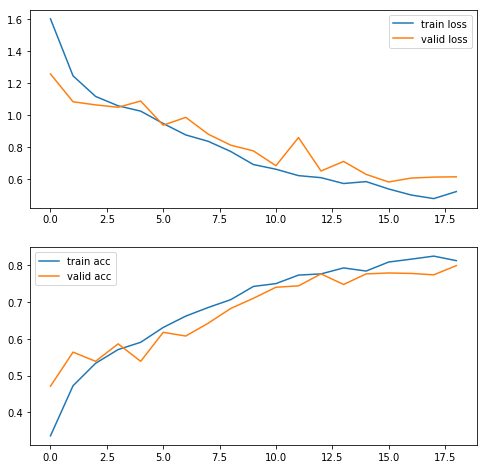

In [11]:

fig, ax = plt.subplots(2, 1, figsize=(8,8))


df = pd.DataFrame()
df['train loss'] = train_data.history['loss']
df['valid loss'] = train_data.history['val_loss']

df2 = pd.DataFrame()
df2['train acc'] = train_data.history['acc']
df2['valid acc'] = train_data.history['val_acc']

df.plot(ax=ax[0])
df2.plot(ax=ax[1])

plt.show()

## 5. Inference

We can now use the trained model to run inference on new images:

In [8]:
# Let's define the preprocessing that an image has 
# to go through before feeding it into the net
def preprocess_image(image):
    # Resize to a network's size
    image = cv2.resize(image, (224,224))
    # Add "batch dimension"
    image = np.expand_dims(image, 0)
    # Normalize since we scaled for augmentation
    image = image / 255
    return  image

In [9]:
# Let's write our inference function
def single_image_inf(model, path):
    # Read in image (account for bgr -> rgb)
    img = cv2.imread(path)[:,:,::-1]
    
    # By calling `predict` on our model, we can run
    # inference on our processed image
    output = model.predict( preprocess_image(img) )[0]
    
    # Format output
    s = pd.Series(output, index=[decode_map[i] for i in range(train_gen.num_classes)])

    # Plot output
    ax = s.sort_values(ascending=False).plot(kind='bar', 
                                             rot=45,
                                            color='slategrey')
    vals = ax.get_yticks()
    a = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    # Find winner
    label = s.idxmax()
    score = s.max()
    print('Prediction: %s (%.2f %%)'%(label, score*100))

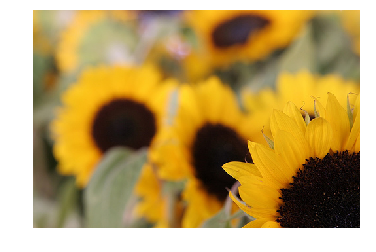

In [10]:
img = cv2.imread('plots/sunflower_validation.jpg')[:,:,::-1]
plt.axis('off')
plt.imshow(img)

In [11]:
# Let's create a new model and load in our trained weights
from keras.applications import VGG16
model2 = update_model(VGG16(), train_gen.num_classes)

model2.load_weights('tutorial_weights.h5')


Prediction: sunflower (78.48 %)


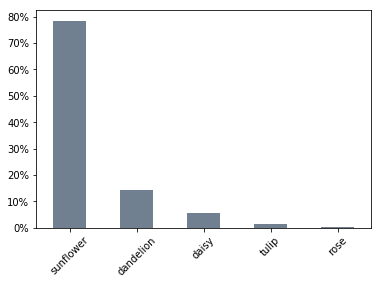

In [12]:
# And now run inference for it
single_image_inf(model2, 'plots/sunflower_validation.jpg')


## 6. Bonus Note!

But what happens if we show our network something different...

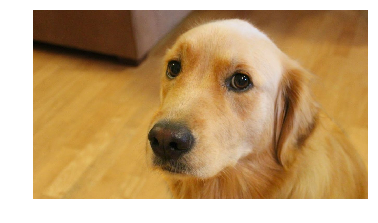

In [13]:
img = cv2.imread('plots/bonus.jpg')[:,:,::-1]
plt.axis('off')
plt.imshow(img)

Prediction: dandelion (71.54 %)


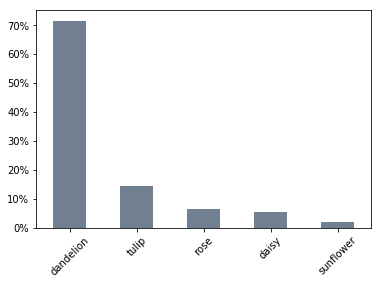

In [14]:
# Let's run inference on it anyway!
single_image_inf(model2, 'plots/bonus.jpg')

We were probably expecting a high entropy output... how can we mitigate this?

- [On calibration of modern neural networks](https://arxiv.org/abs/1706.04599)
- [What Image Classifiers Can Do About Unknown Objects](https://petewarden.com/2018/07/06/what-image-classifiers-can-do-about-unknown-objects/)